In [1]:
import os
from os import path
from collections import defaultdict
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import LinearSVC
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import GridSearchCV
from keras.layers import Input
from keras.models import Model
from keras.layers import Dense 
from keras.utils.vis_utils import plot_model
from keras.models import model_from_json 
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve, auc, completeness_score, homogeneity_score, v_measure_score, confusion_matrix, zero_one_loss

warnings.filterwarnings('ignore')

## Reading and processing dataset 

In [2]:
dataset_root = '../datasets/nsl-kdd'

train_file = os.path.join(dataset_root, 'KDDTrain+.txt')
test_file = os.path.join(dataset_root, 'KDDTest+.txt')

header_names = ['duration', 'protocol_type', 'service', 'flag', 'src_bytes', 'dst_bytes', 'land', 'wrong_fragment', 'urgent', 'hot', 'num_failed_logins', 'logged_in', 'num_compromised', 'root_shell', 'su_attempted', 'num_root', 'num_file_creations', 'num_shells', 'num_access_files', 'num_outbound_cmds', 'is_host_login', 'is_guest_login', 'count', 'srv_count', 'serror_rate', 'srv_serror_rate', 'rerror_rate', 'srv_rerror_rate', 'same_srv_rate', 'diff_srv_rate', 'srv_diff_host_rate', 'dst_host_count', 'dst_host_srv_count', 'dst_host_same_srv_rate', 'dst_host_diff_srv_rate', 'dst_host_same_src_port_rate', 'dst_host_srv_diff_host_rate', 'dst_host_serror_rate', 'dst_host_srv_serror_rate', 'dst_host_rerror_rate', 'dst_host_srv_rerror_rate', 'attack_type', 'success_pred']
col_names = np.array(header_names)

nominal_idx = [1, 2, 3]
binary_idx = [6, 11, 13, 14, 20, 21]
numeric_idx = list(set(range(41)).difference(nominal_idx).difference(binary_idx))

nominal_cols = col_names[nominal_idx].tolist()
binary_cols = col_names[binary_idx].tolist()
numeric_cols = col_names[numeric_idx].tolist()

# training_attack_types.txt maps each of the 22 different attacks to 1 of 4 categories

category = defaultdict(list)
category['benign'].append('normal')

with open('../datasets/training_attack_types.txt', 'r') as f:
    for line in f.readlines():
        attack, cat = line.strip().split(' ')
        category[cat].append(attack)

attack_mapping = dict((v,k) for k in category for v in category[k])

## Generating and analyzing train and test sets

In [3]:
train_df = pd.read_csv(train_file, names=header_names)
train_df['attack_category'] = train_df['attack_type'] \
                                .map(lambda x: attack_mapping[x])
train_df.drop(['success_pred'], axis=1, inplace=True)
    
test_df = pd.read_csv(test_file, names=header_names)
test_df['attack_category'] = test_df['attack_type'] \
                                .map(lambda x: attack_mapping[x])
test_df.drop(['success_pred'], axis=1, inplace=True)

train_attack_types = train_df['attack_type'].value_counts()
train_attack_cats = train_df['attack_category'].value_counts()

test_attack_types = test_df['attack_type'].value_counts()
test_attack_cats = test_df['attack_category'].value_counts()

<Axes: ylabel='attack_type'>

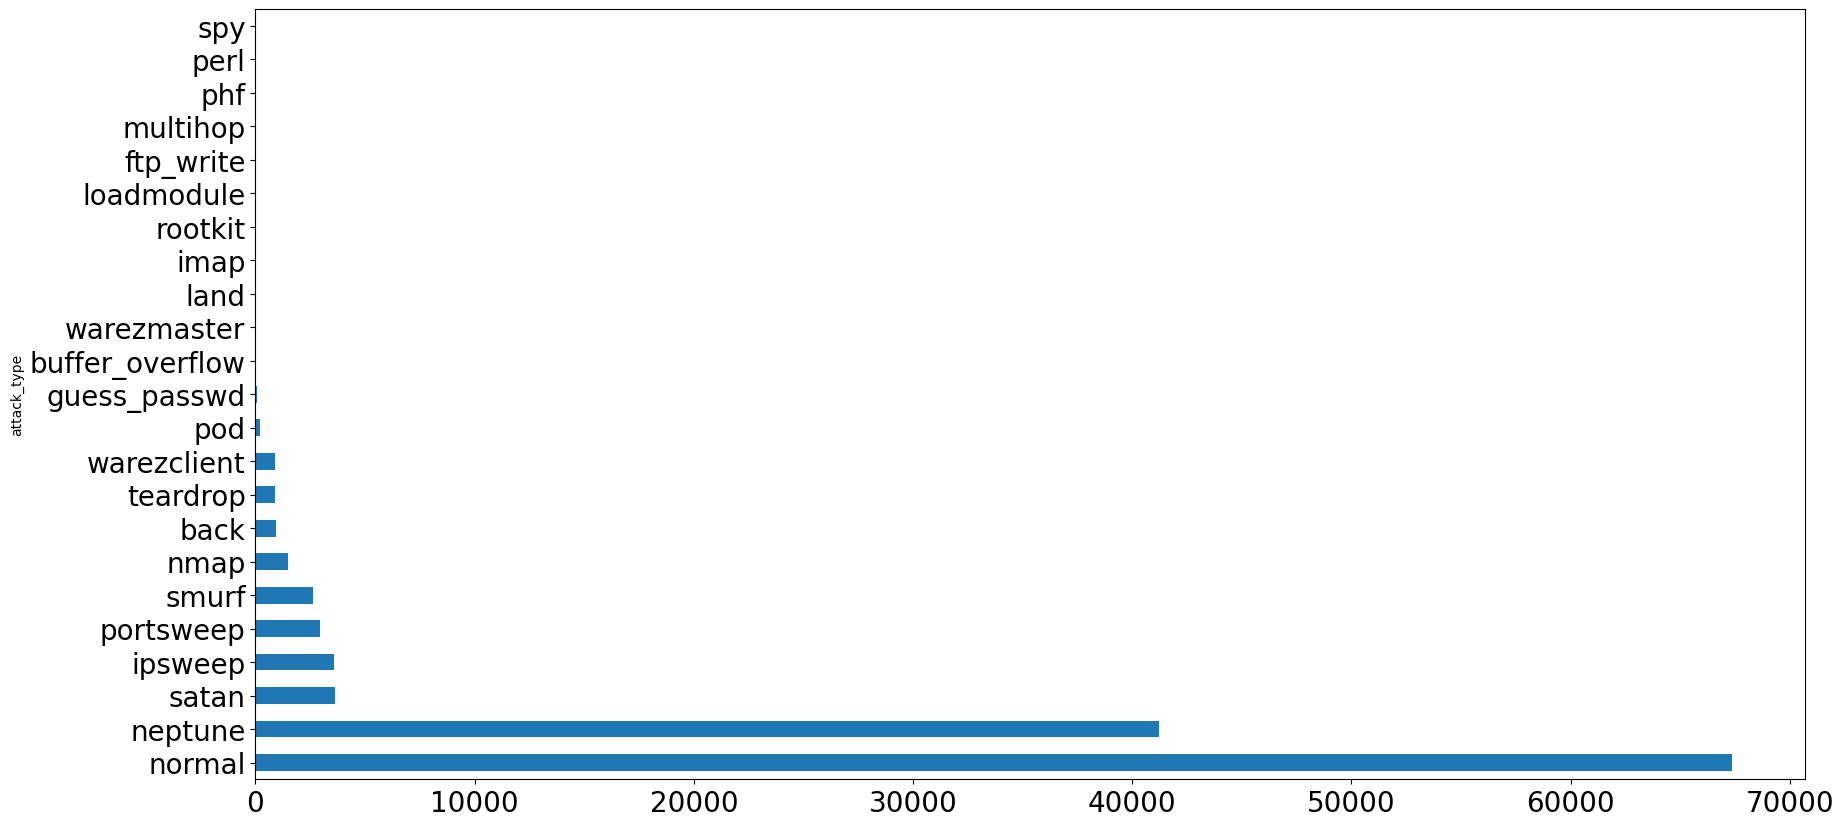

In [4]:
train_attack_types.plot(kind='barh', figsize=(20,10), fontsize=20)

<Axes: ylabel='attack_category'>

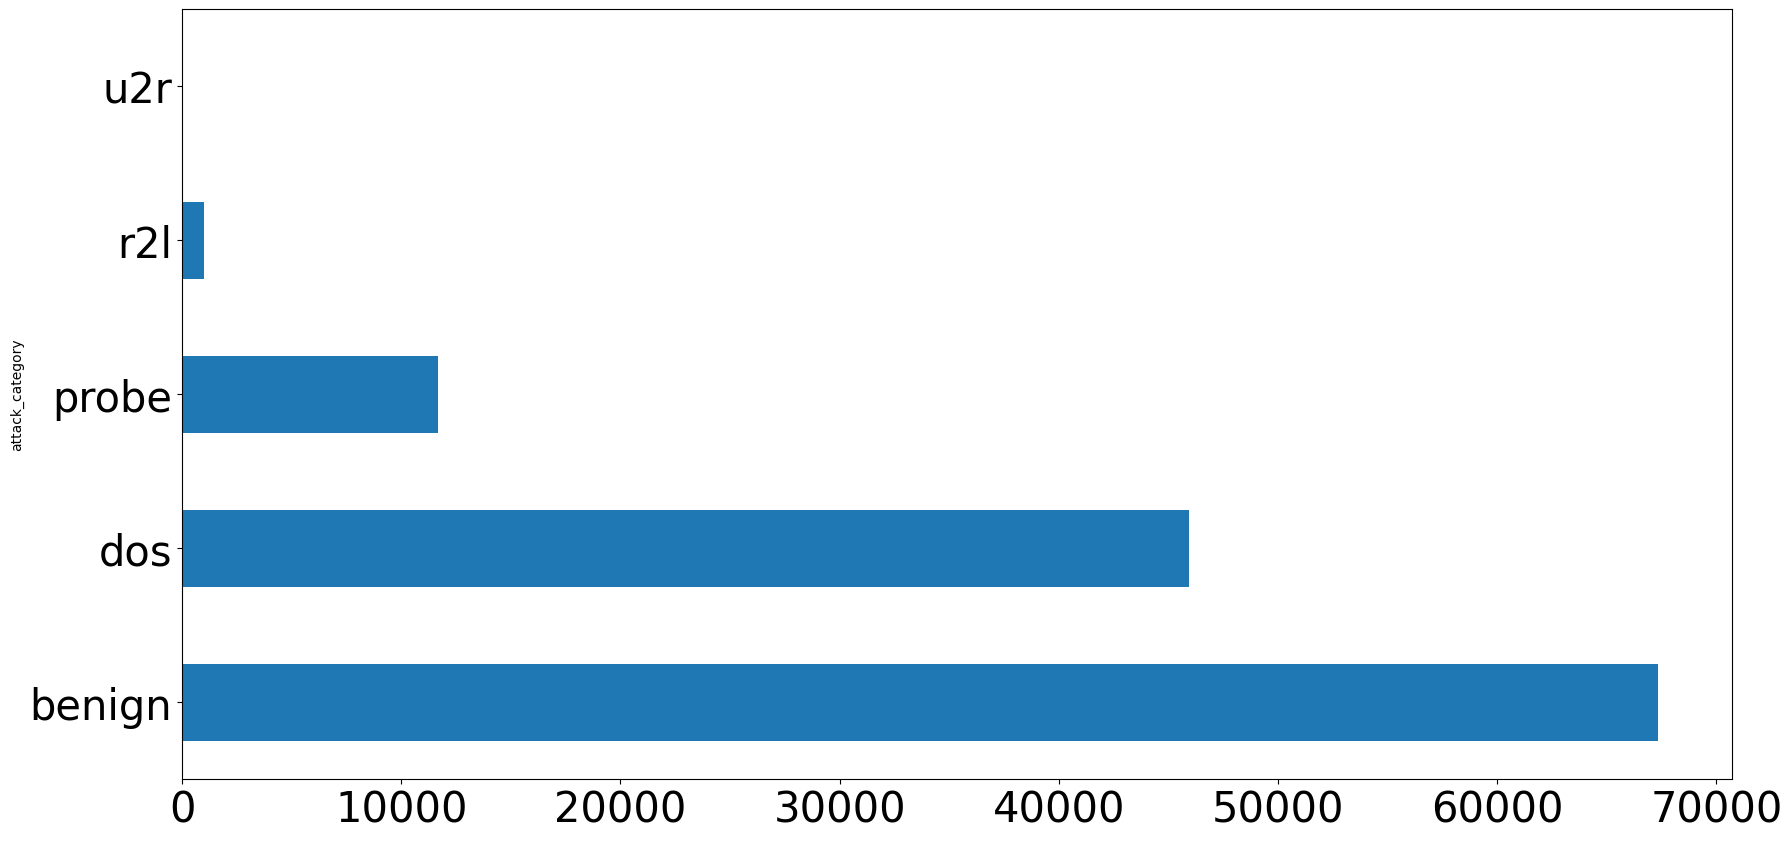

In [5]:
train_attack_cats.plot(kind='barh', figsize=(20,10), fontsize=30)

<Axes: ylabel='attack_type'>

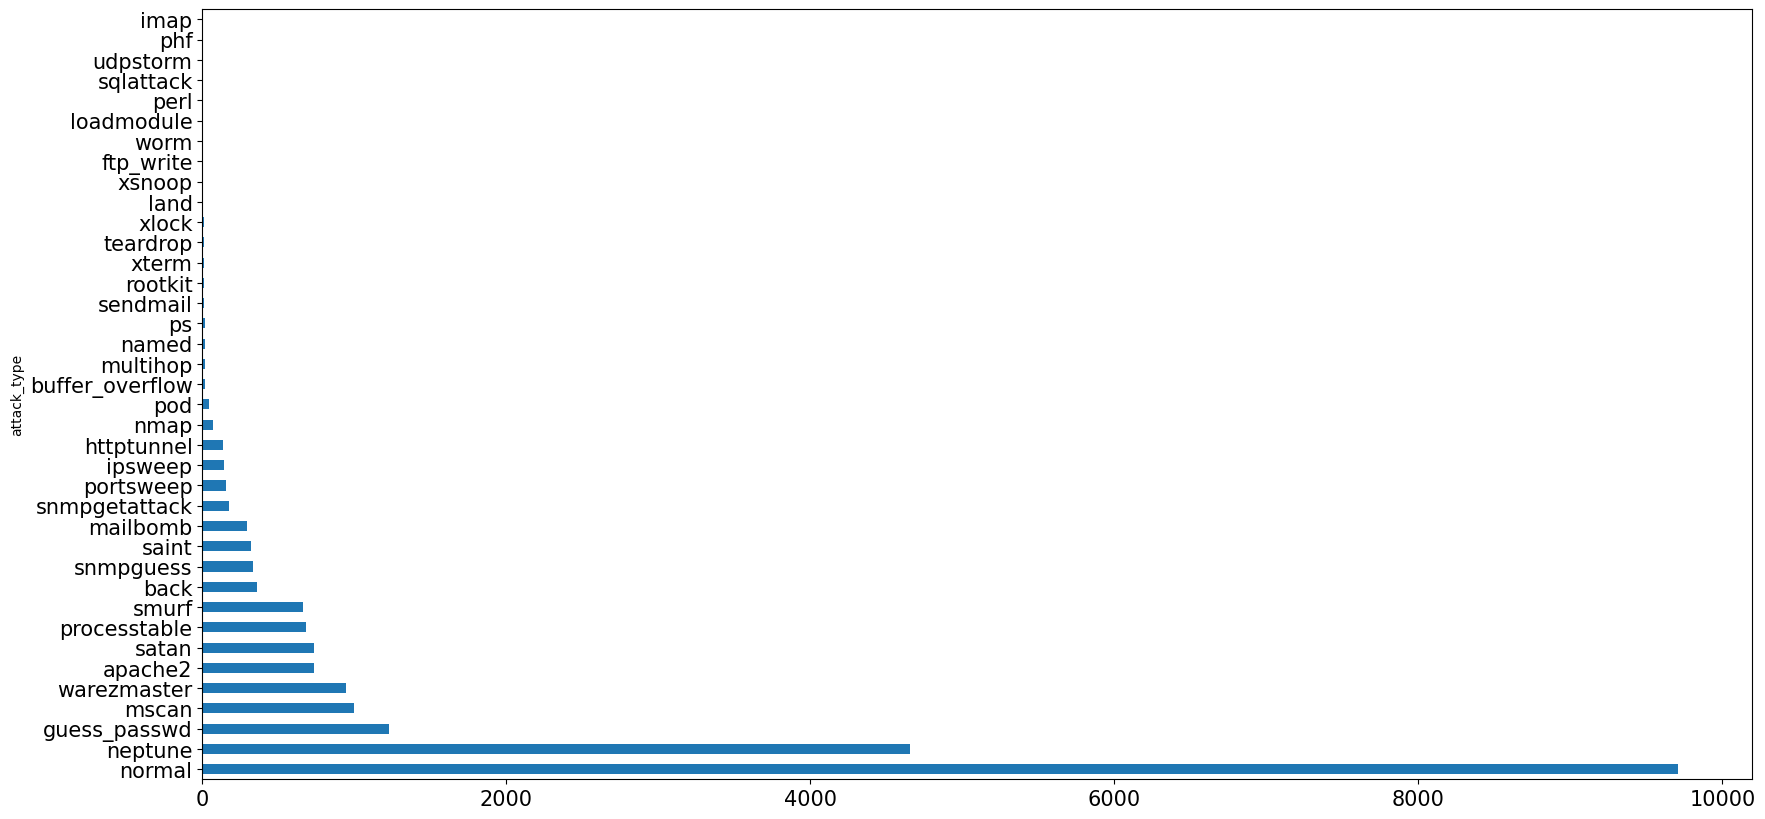

In [6]:
test_attack_types.plot(kind='barh', figsize=(20,10), fontsize=15)

<Axes: ylabel='attack_category'>

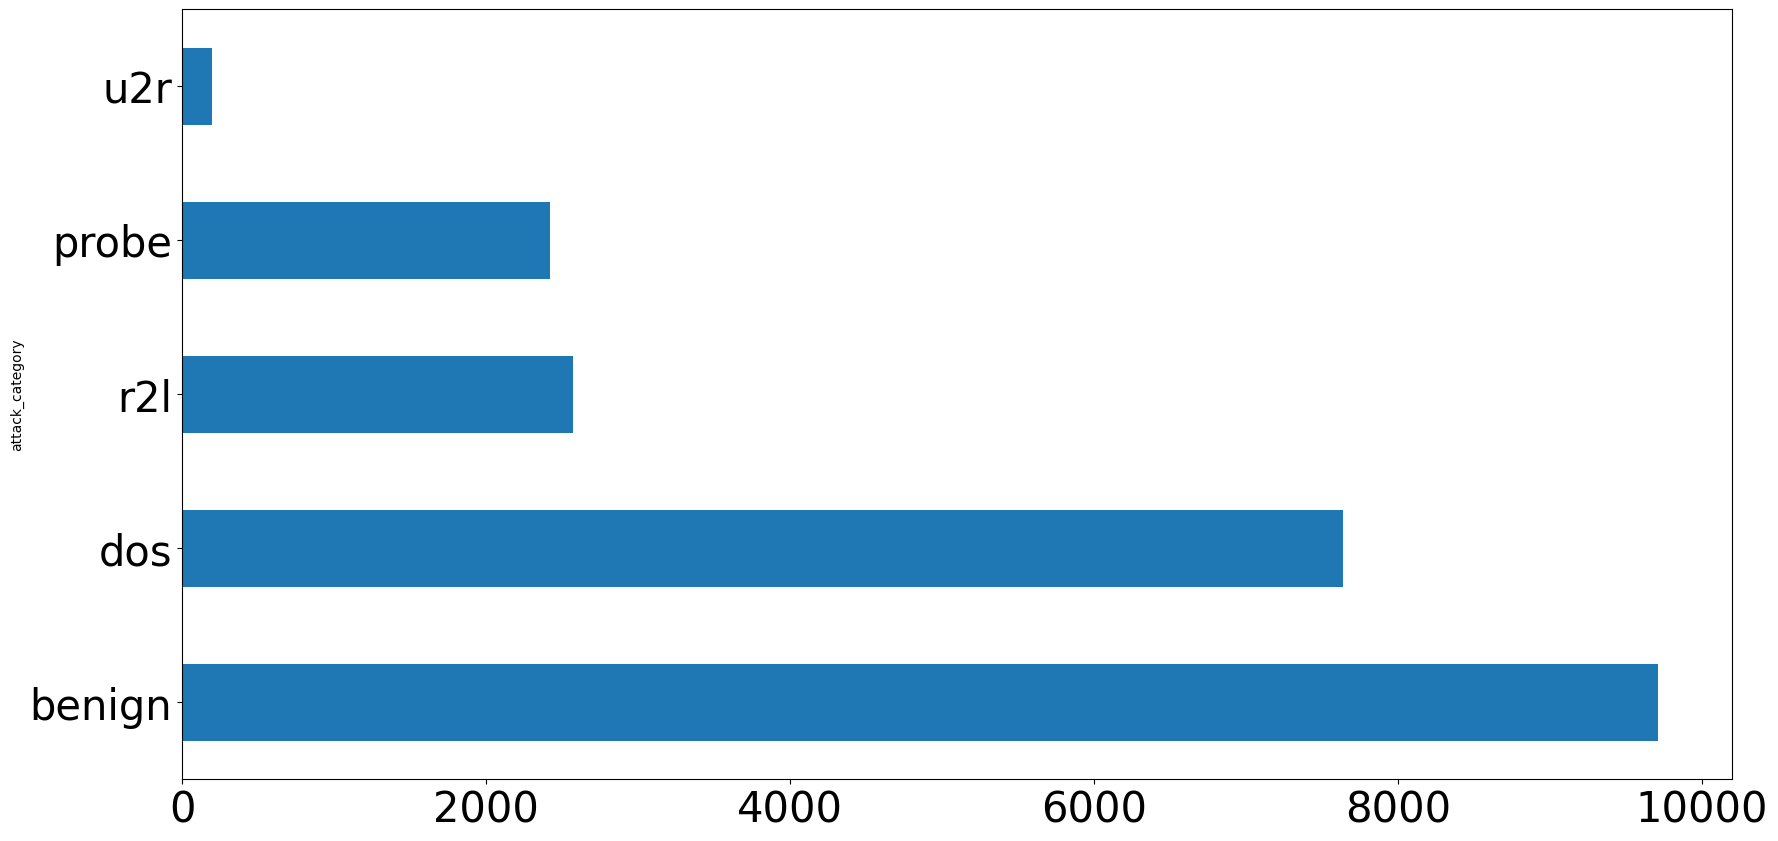

In [7]:
test_attack_cats.plot(kind='barh', figsize=(20,10), fontsize=30)

#### 값 대체, 불필요한 feature 제거

In [8]:
# binary features 확인

train_df[binary_cols].describe().transpose()

,count,mean,std,min,25%,50%,75%,max
land,125973.0,0.000198,0.014086,0.0,0.0,0.0,0.0,1.0
logged_in,125973.0,0.395736,0.489010,0.0,0.0,0.0,1.0,1.0
root_shell,125973.0,0.001342,0.036603,0.0,0.0,0.0,0.0,1.0
su_attempted,125973.0,0.001103,0.045154,0.0,0.0,0.0,0.0,2.0
is_host_login,125973.0,0.000008,0.002817,0.0,0.0,0.0,0.0,1.0
is_guest_login,125973.0,0.009423,0.096612,0.0,0.0,0.0,0.0,1.0


In [9]:
# 0과 1 이외의 값이 있는 feature 찾기

train_df.groupby(['su_attempted']).size()

su_attempted
0    125893
1        21
2        59
dtype: int64

In [10]:
# su_attempted = 2인 경우 0으로 대체

train_df['su_attempted'].replace(2, 0, inplace=True)
test_df['su_attempted'].replace(2, 0, inplace=True)
train_df.groupby(['su_attempted']).size()

su_attempted
0    125952
1        21
dtype: int64

In [11]:
# Next, we notice that the num_outbound_cmds column only takes on one value!

train_df.groupby(['num_outbound_cmds']).size()

num_outbound_cmds
0    125973
dtype: int64

In [12]:
# Now, that's not a very useful feature - let's drop it from the dataset

train_df.drop('num_outbound_cmds', axis = 1, inplace=True)
test_df.drop('num_outbound_cmds', axis = 1, inplace=True)
numeric_cols.remove('num_outbound_cmds')

In [13]:
train_Y = train_df['attack_category']
train_x_raw = train_df.drop(['attack_category','attack_type'], axis=1)
test_Y = test_df['attack_category']
test_x_raw = test_df.drop(['attack_category','attack_type'], axis=1)

## Data Normalization

#### Nominal data -> one-hot encoding

In [14]:
combined_df_raw = pd.concat([train_x_raw, test_x_raw])
combined_df = pd.get_dummies(combined_df_raw, columns=nominal_cols, drop_first=True) 

train_x = combined_df[:len(train_x_raw)]
test_x = combined_df[len(train_x_raw):]

#### Numerical data -> Scaling

In [15]:
# Example statistics for the 'duration' feature before scaling
train_x['duration'].describe()

count    125973.00000
mean        287.14465
std        2604.51531
min           0.00000
25%           0.00000
50%           0.00000
75%           0.00000
max       42908.00000
Name: duration, dtype: float64

In [16]:
# Experimenting with StandardScaler on the single 'duration' feature

durations = train_x['duration'].values.reshape(-1, 1)
standard_scaler = StandardScaler().fit(durations)
scaled_durations = standard_scaler.transform(durations)
pd.Series(scaled_durations.flatten()).describe()

count    1.259730e+05
mean     2.549477e-17
std      1.000004e+00
min     -1.102492e-01
25%     -1.102492e-01
50%     -1.102492e-01
75%     -1.102492e-01
max      1.636428e+01
dtype: float64

In [17]:
# Experimenting with MinMaxScaler on the single 'duration' feature

min_max_scaler = MinMaxScaler().fit(durations)
min_max_scaled_durations = min_max_scaler.transform(durations)
pd.Series(min_max_scaled_durations.flatten()).describe()

count    125973.000000
mean          0.006692
std           0.060700
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max           1.000000
dtype: float64

In [18]:
# Experimenting with RobustScaler on the single 'duration' feature

min_max_scaler = RobustScaler().fit(durations)
robust_scaled_durations = min_max_scaler.transform(durations)
pd.Series(robust_scaled_durations.flatten()).describe()

count    125973.00000
mean        287.14465
std        2604.51531
min           0.00000
25%           0.00000
50%           0.00000
75%           0.00000
max       42908.00000
dtype: float64

In [19]:
# Let's proceed with StandardScaler- Apply to all the numeric columns

standard_scaler = StandardScaler().fit(train_x[numeric_cols])

train_x[numeric_cols] = standard_scaler.transform(train_x[numeric_cols])
test_x[numeric_cols] = standard_scaler.transform(test_x[numeric_cols])

## Dealing with class imbalance

#### 각 category의 비율이 어떤지 확인해보기

In [20]:
test_Y.value_counts().apply(lambda x: x/float(len(test_Y)))

attack_category
benign    0.430758
dos       0.338715
r2l       0.114177
probe     0.107479
u2r       0.008872
Name: count, dtype: float64

In [21]:
train_Y.value_counts().apply(lambda x: x/float(len(train_Y)))

attack_category
benign    0.534583
dos       0.364578
probe     0.092528
r2l       0.007899
u2r       0.000413
Name: count, dtype: float64

In [22]:
print(pd.Series(train_Y).value_counts())

attack_category
benign    67343
dos       45927
probe     11656
r2l         995
u2r          52
Name: count, dtype: int64


#### i) SMOTE
Random Oversampling: Randomly duplicate examples in the minority class.

In [23]:
sm = SMOTE(random_state=0) # ratio='auto' 삭제함

train_x_sm, train_Y_sm = sm.fit_resample(train_x, train_Y)

print(pd.Series(train_Y_sm).value_counts())

attack_category
benign    67343
dos       67343
r2l       67343
probe     67343
u2r       67343
Name: count, dtype: int64


#### ii) RandomUnderSampler
Random Undersampling: Randomly delete examples in the majority class.

In [24]:
mean_class_size = int(pd.Series(train_Y).value_counts().sum()/5)
ratio = {'benign': mean_class_size,
         'dos': mean_class_size,
         'probe': mean_class_size,
         'r2l': mean_class_size,
         'u2r': mean_class_size}
rus = RandomUnderSampler(random_state=0, replacement=True) # ratio=ratio 삭제

train_x_rus, train_Y_rus = rus.fit_resample(train_x_sm, train_Y_sm)

print(pd.Series(train_Y_rus).value_counts())

attack_category
benign    67343
dos       67343
probe     67343
r2l       67343
u2r       67343
Name: count, dtype: int64


## Feature selection

In [25]:
ETC = ExtraTreesClassifier(n_estimators = 5)
 
ETC.fit(train_x_rus, train_Y_rus) # ETC 모델 학습
feature_importance = ETC.feature_importances_ # 각 feature의 importance
feature_importance_normalized = np.std([tree.feature_importances_ for tree in # 각 importance들을 normalize
                                        ETC.estimators_],
                                        axis = 0)

feature_importance_df = pd.DataFrame({ # 모든 feature와 각각의 importance가 있는 dataframe 생성
    'feature': train_x_rus.columns,
    'importance': feature_importance
})

feature_importance_df = feature_importance_df.sort_values(by='importance', ascending=False) # 위 dataframe을 importance를 기준으로 내림차순으로 sort

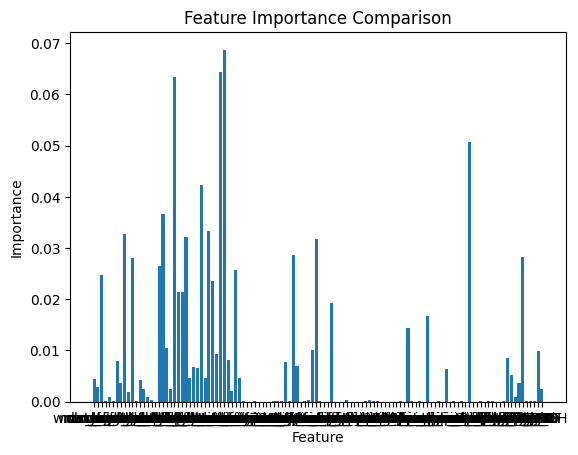

High Importance Feature:
                     feature  importance
98            service_telnet    0.077787
28        dst_host_srv_count    0.063508
33      dst_host_serror_rate    0.057523
52             service_eco_i    0.055496
27            dst_host_count    0.047088
30    dst_host_diff_srv_rate    0.045001
17            is_guest_login    0.043688
58          service_ftp_data    0.041485
34  dst_host_srv_serror_rate    0.037061
8                  logged_in    0.036155
>>> selected_cols above threshold:
 ['service_telnet', 'dst_host_srv_count', 'dst_host_serror_rate', 'service_eco_i', 'dst_host_count', 'dst_host_diff_srv_rate', 'is_guest_login', 'service_ftp_data', 'dst_host_srv_serror_rate', 'logged_in', 'same_srv_rate', 'root_shell', 'srv_serror_rate', 'count', 'dst_bytes', 'protocol_type_tcp', 'dst_host_same_src_port_rate', 'service_private', 'dst_host_srv_diff_host_rate']


In [26]:
# 각 feature의 importance를 bar graph에서 비교
plt.bar(train_x_rus.columns, feature_importance_normalized)
plt.xlabel('Feature')
plt.ylabel('Importance')
plt.title('Feature Importance Comparison')
plt.show()

# Display the top features
print("High Importance Feature:")
print(feature_importance_df.head(10)) 

# importance threshold를 기준으로 feature selection
selected_features = feature_importance_df[feature_importance_df['importance'] > 0.02]['feature']
selected_cols = selected_features.tolist() 

selected_cols = [feature for feature in selected_cols if feature != 'urgent'] 
    # urgent packet은 real world에서 더이상 발생하지 않으므로, 'urgent' feature을 버린다
    
print(">>> selected_cols above threshold:\n", selected_cols)  

# x에 적용
train_x_rus_selected = train_x_rus[selected_cols]
test_x_selected = test_x[selected_cols]

## Train & Test

In [27]:
# dataset shape 확인
print(">>> train_x_rus_selected.shape:\n", train_x_rus_selected.shape)
print(">>> test_x_selected.shape:\n", test_x_selected.shape)
print(">>> train_Y_rus.shape:\n", train_Y_rus.shape)
print(">>> test_Y.shape:\n", test_Y.shape)

>>> train_x_rus_selected.shape:
 (336715, 19)
>>> test_x_selected.shape:
 (22544, 19)
>>> train_Y_rus.shape:
 (336715,)
>>> test_Y.shape:
 (22544,)


### using AE

In [32]:
# y의 label값을 string에서 0~4로 매치시키기
one_hot_encoder = OneHotEncoder(dtype=int, sparse_output=False)
test_Y_encoded = one_hot_encoder.fit_transform(test_Y.values.reshape(-1, 1))
test_Y_int = np.argmax(test_Y_encoded, axis=1) # test_Y_encoded에서 매 row에 대해 axis=1을 따라 최대값을 갖는 요소의 col값을 반환

##### i) AutoEncoder 

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 19)]              0         
                                                                 
 dense_4 (Dense)             (None, 50)                1000      
                                                                 
 dense_5 (Dense)             (None, 19)                969       
                                                                 
Total params: 1,969
Trainable params: 1,969
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
674/674 [==============================] - 1s 1ms/step - loss: 0.7105 - accuracy: 0.4869 - val_loss: 0.4269 - val_accuracy: 0.4132
Epoch 2/100
674/674 [==============================] - 1s 953us/step - loss: 0.6839 - accuracy: 0.7004 - val_loss: 0.4177 - val_accuracy: 0.8179
Epoch 3/100
674/674 [============

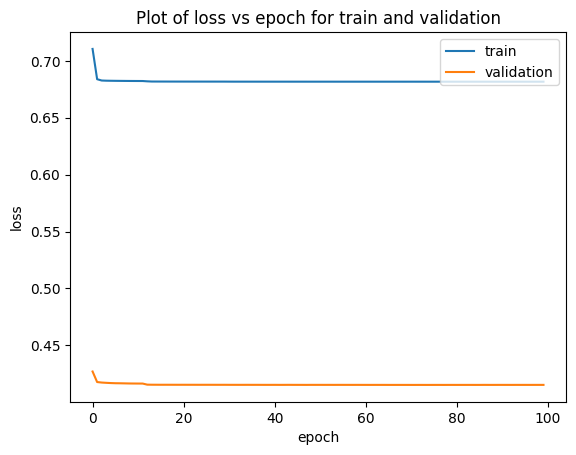

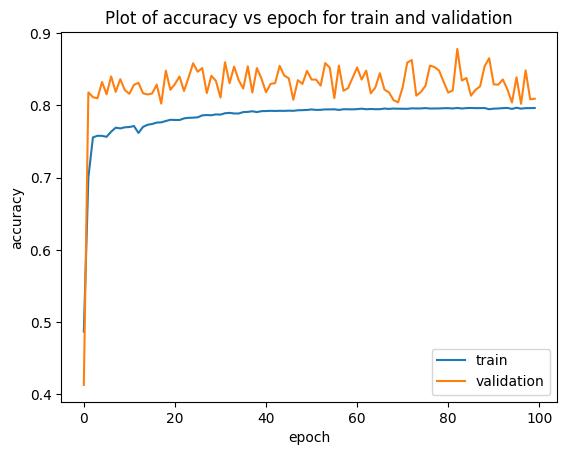

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.
705/705 [==============================] - 0s 530us/step


In [33]:
encoding_dim = 50
input_dim = train_x_rus_selected.shape[1] # selected feature의 개수임

# input layer
input_layer = Input(shape=(input_dim, ))
# encoding layer: with 50 neurons
encoder = Dense(encoding_dim, activation="relu")(input_layer)           
# output layer
output_layer = Dense(input_dim, activation='softmax')(encoder)

# AutoEncoder 모델 생성
autoencoder = Model(inputs=input_layer, outputs=output_layer)

# optimizer, loss, metrics 설정하여 모델 compile
autoencoder.compile(optimizer='adam', loss='mean_squared_error',metrics=['accuracy'])

# model layers summary
autoencoder.summary()

# 모델 training
history = autoencoder.fit(train_x_rus_selected.astype('float32'), train_x_rus_selected.astype('float32'), \
                          epochs=100, batch_size=500, validation_data=(test_x_selected.astype('float32'), test_x_selected.astype('float32'))).history

# validation
validation_results = autoencoder.evaluate(test_x_selected.astype('float32'), test_x_selected.astype('float32'), verbose=1)
print(f'Validation results - Loss: {validation_results[0]} - Accuracy: {validation_results[1]*100}%')

# train과 validation 각각, epoch에 대한 loss plot
plt.plot(history['loss'])
plt.plot(history['val_loss'])
plt.title("Plot of loss vs epoch for train and validation")
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.savefig('../results/ae_multi_loss.png')
plt.show()

# train과 validation 각각, epoch에 대한 accuracy plot
plt.plot(history['accuracy'])
plt.plot(history['val_accuracy'])
plt.title("Plot of accuracy vs epoch for train and validation")
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='best')
plt.savefig('../results/ae_multi_accuracy.png')
plt.show()

# representation of model layers
plot_model(autoencoder, to_file='../results/ae_multi.png', show_shapes=True,)

# predict
ae_pred = autoencoder.predict(test_x_selected.astype('float32'))

##### ii) AE classifier

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 19)]              0         
                                                                 
 dense_8 (Dense)             (None, 48)                960       
                                                                 
 dense_9 (Dense)             (None, 5)                 245       
                                                                 
Total params: 1,205
Trainable params: 1,205
Non-trainable params: 0
_________________________________________________________________
Epoch 1/200
26/26 [==============================] - 0s 5ms/step - loss: 0.2225 - accuracy: 0.0086 - val_loss: 0.1891 - val_accuracy: 0.0098
Epoch 2/200
26/26 [==============================] - 0s 2ms/step - loss: 0.1713 - accuracy: 0.2595 - val_loss: 0.1565 - val_accuracy: 0.4347
Epoch 3/200
26/26 [====================

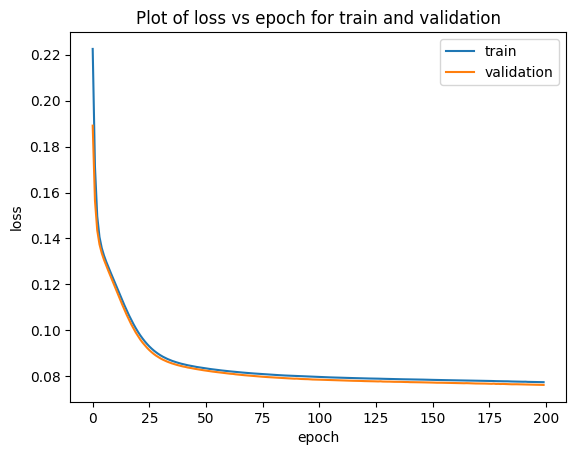

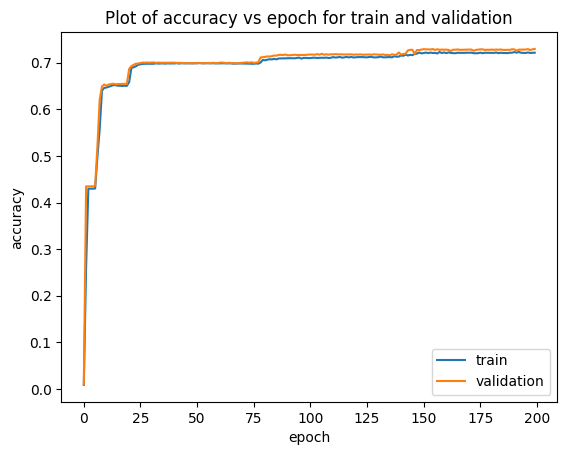

705/705 [==============================] - 0s 572us/step
>>> Confusion matrix:
 [[9262   55  196  198    0]
 [1969 4972  282  413    0]
 [ 500  825  910  188    0]
 [2075    6  105  388    0]
 [  87    3   18   92    0]]
>>> error:
 0.3110361958836054


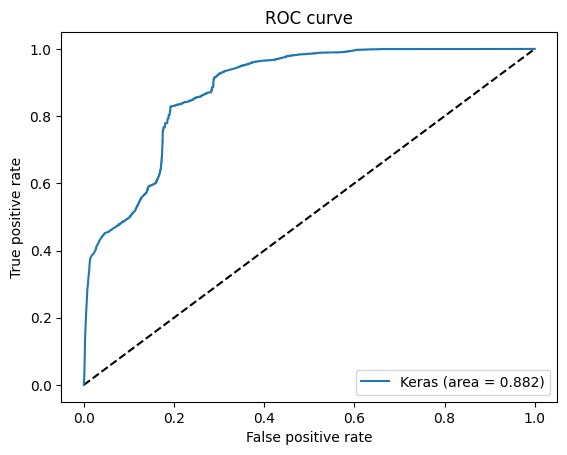

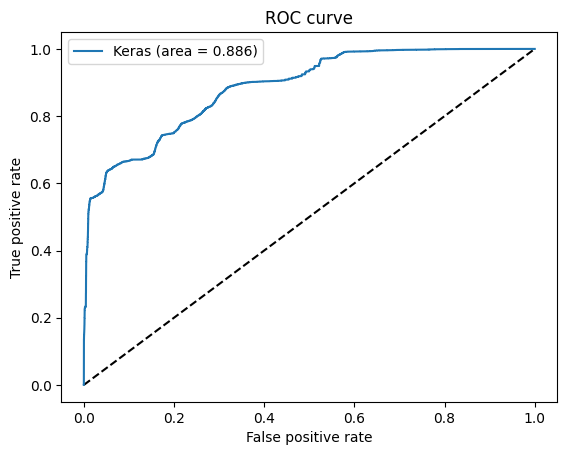

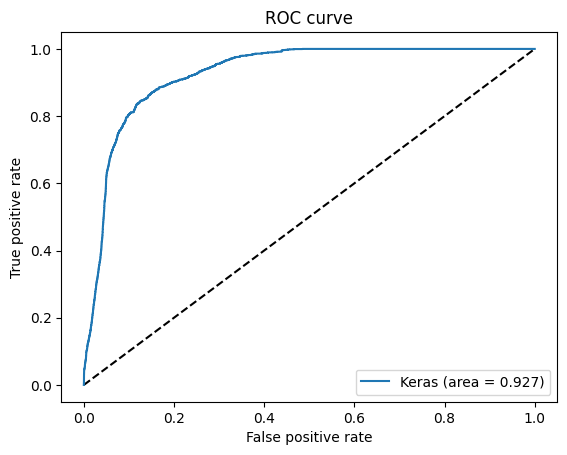

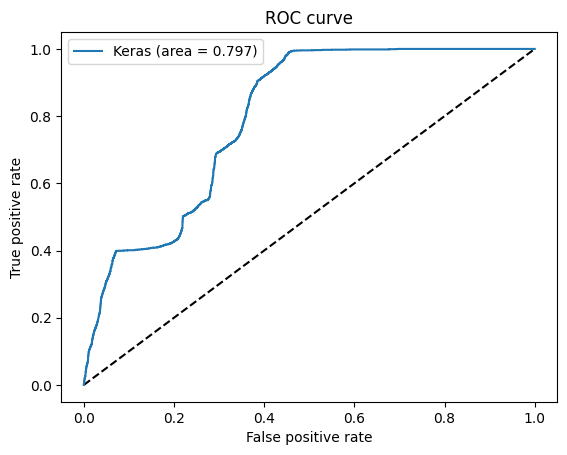

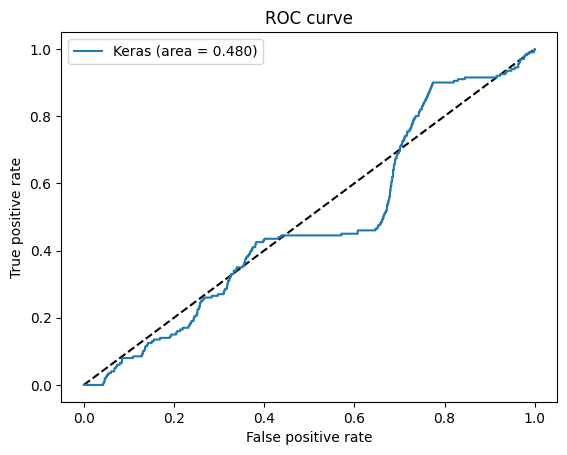

Recall Score -  0.8096167494677076
F1 Score -  0.6520667357364868
Precision Score -  0.5458460434236497


In [35]:
input_dim = ae_pred.shape[1]

#input layer
input_layer = Input(shape=(input_dim, ))
#hidden layer: with 48 neurons
fvector = Dense(48, activation="sigmoid")(input_layer)   
# output layer
output_layer = Dense(5, activation='sigmoid')(fvector)

# AE classifier 모델 생성
ae_classifier = Model(inputs=input_layer, outputs=output_layer)

# optimizer, loss, metrics 설정하여 모델 compile
ae_classifier.compile(optimizer='adam', loss='mean_squared_error',metrics=['accuracy'])

# model layers summary
ae_classifier.summary()

# 모델 training
history = ae_classifier.fit(ae_pred, test_Y_encoded, epochs=200, batch_size=700, validation_split=0.2).history

# validation
validation_results = ae_classifier.evaluate(test_x_selected.astype('float32'), test_Y_encoded.astype('float32'), verbose=1)
print(f'Validation results - Loss: {validation_results[0]} - Accuracy: {validation_results[1]*100}%')

# representation of model layers
plot_model(ae_classifier, to_file='../results/ae_classifier_multi.png', show_shapes=True)

# train과 validation 각각, epoch에 대한 loss plot
plt.plot(history['loss'])
plt.plot(history['val_loss'])
plt.title("Plot of loss vs epoch for train and validation")
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.savefig('../results/ae_classifier_multi_loss.png')
plt.show()

# train과 validation 각각, epoch에 대한 accuracy plot
plt.plot(history['accuracy'])
plt.plot(history['val_accuracy'])
plt.title("Plot of accuracy vs epoch for train and validation")
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='best')
plt.savefig('../results/ae_classifier_multi_accuracy.png')
plt.show()

# predict
pred_y = ae_classifier.predict(test_x_selected.astype('float32'))

# confusion matrix
pred_y_highest = np.argmax(pred_y, axis=1)
results = confusion_matrix(test_Y_int, pred_y_highest)
print(">>> Confusion matrix:\n", results)

# error
error = zero_one_loss(test_Y_int, pred_y_highest)
print(">>> error:\n", error)

# ROC Curve

n_classes = 5

fpr_ae = dict()
tpr_ae = dict()
roc_auc_ae = dict()
for i in range(n_classes):
    fpr_ae[i], tpr_ae[i], _ = roc_curve(test_Y_encoded[:, i], pred_y[:, i])
    roc_auc_ae[i] = auc(fpr_ae[i], tpr_ae[i])

for i in range(n_classes):
  plt.plot([0, 1], [0, 1], 'k--')
  plt.plot(fpr_ae[i], tpr_ae[i], label='Keras (area = {:.3f})'.format(roc_auc_ae[i]))
  plt.xlabel('False positive rate')
  plt.ylabel('True positive rate')
  plt.title('ROC curve')
  plt.legend(loc='best')
  plt.savefig('../results/ae_classifier_multi_roc'+str(i)+'.png')
  plt.show()

# metrics

for j in range(0, pred_y.shape[1]):
  for i in range(0, pred_y.shape[0]):
    pred_y[i][j] = int(round(pred_y[i][j]))

print("Recall Score - ",recall_score(test_Y_encoded, pred_y.astype('uint8'), average='micro'))
print("F1 Score - ",f1_score(test_Y_encoded, pred_y.astype('uint8'), average='micro'))
print("Precision Score - ",precision_score(test_Y_encoded, pred_y.astype('uint8'), average='micro'))

### using MLP

In [31]:
param_grid = { # 다양한 설정에 대한 모든 경우의 수를 전부 수행해보기
    'hidden_layer_sizes': [(20, 10), (30, 20, 10)],
    'activation': ['relu'],
    'solver': ['adam'],
    'max_iter': [256, 512]
}
grid_search = GridSearchCV(MLPClassifier(random_state=42), param_grid, cv=5, n_jobs=-1)

grid_search.fit(train_x_rus_selected, train_Y_rus)

best_model = grid_search.best_estimator_ # 그 중 최고의 성능을 낸 estimator 반환
pred_y = best_model.predict(test_x_selected) # 최고의 모델로 prediction

# confusion matrix
label_encoder = LabelEncoder()
pred_y_int = label_encoder.fit_transform(pred_y)
results = confusion_matrix(test_Y_int, pred_y_int)
print(">>> Confusion matrix:\n", results)

# error
error = zero_one_loss(test_Y_int, pred_y_int)
print(">>> error:\n", error)

print("Best Model from GridSearchCV")
print(f"Best Parameters: {grid_search.best_params_}")
print(f"Accuracy: {accuracy_score(test_Y_int, pred_y_int)}")
print("Classification Report:")
print(classification_report(test_Y_int, pred_y_int))
print('Completeness: {}'.format(completeness_score(test_Y_int, pred_y_int))) # ~1. 클수록 좋음
print('Homogeneity: {}'.format(homogeneity_score(test_Y_int, pred_y_int))) # 0~1. 클수록 좋음
print('V-measure: {}'.format(v_measure_score(test_Y_int, pred_y_int))) # homogeneity와 completeness의 평균

>>> Confusion matrix:
 [[8902  514  238   44   13]
 [1745 5339   92  460    0]
 [ 751  161 1475   28    8]
 [1898    3  156  451   66]
 [ 170    0    0    4   26]]
>>> error:
 0.28171575585521647
Best Model from GridSearchCV
Best Parameters: {'activation': 'relu', 'hidden_layer_sizes': (30, 20, 10), 'max_iter': 256, 'solver': 'adam'}
Accuracy: 0.7182842441447835
Classification Report:
              precision    recall  f1-score   support

           0       0.66      0.92      0.77      9711
           1       0.89      0.70      0.78      7636
           2       0.75      0.61      0.67      2423
           3       0.46      0.18      0.25      2574
           4       0.23      0.13      0.17       200

    accuracy                           0.72     22544
   macro avg       0.60      0.51      0.53     22544
weighted avg       0.72      0.72      0.70     22544

Completeness: 0.3983961666483867
Homogeneity: 0.3279477561999168
V-measure: 0.3597555505624389
